# Notebook 6

This notebook:
1. Trains LearningAgent vs StrategicAgent for 50 generations on ppt_train
2. Tracks program-choice entropy (rsa_program) and lexeme-mapping entropy
3. Freezes final state and evaluates on ppt_test (unseen participant)
4. Validate Generalization on the test set

In [6]:
import os
import sys
import random
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

if os.path.basename(os.getcwd()) == "notebooks_new":
    ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), ".."))
else:
    ROOT_DIR = os.path.abspath(os.getcwd())
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

from model.transmission.transmission_chain import run_comm_chain_bayes_rsa

In [39]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

SHOW_PLOTS = True
OUT_DIR = os.path.join(ROOT_DIR, "results", "comm")
os.makedirs(OUT_DIR, exist_ok=True)

PPT_TRAIN = 1
SOURCE_SUBDIR = "programs_for_you"
LEXEMES = ["blah", "blab", "bloop", "bleep", "floop"]

N_GEN = 20
SPEAKER_MODES = ["literal_step", "rsa_program"]

SPEAKER_ALPHA_PROG = 2.0
SPEAKER_ALPHA_UTT = 2.0
SPEAKER_BETA_COST = 0.30
EPSILON = 0.01

# GATED_PARAMS = {
#     "min_attempts": 5,
#     "min_success_rate": 0.4,
#     "p_innovate": 0.08,
#     "pre_promote_chunk_correct": 0.60,
#     "max_promote_per_gen": 1,
# }

NOGATE_PARAMS = {
    "min_attempts": 0,
    "min_success_rate": 0.0,
    "p_innovate": 1.0,
    "pre_promote_chunk_correct": 1.0,
    "max_promote_per_gen": 99,
}

USE_PARALLEL = True
TRACE_GENS = [0, int(N_GEN // 2), int(N_GEN - 1)]

# Generalization test
TEST_PPT_IDS = list(range(2, 10))
TEST_NUM_REPEATS = 3
TEST_MAX_WORKERS = 6



In [40]:
def train_model(params, label):
    df, traces, final_state = run_comm_chain_bayes_rsa(
        ppt_id=PPT_TRAIN,
        data_model_dir=os.path.join(ROOT_DIR, "data", "model"),
        num_generations=N_GEN,
        lexemes=LEXEMES,
        speaker_mode=str(label),
        min_attempts=params["min_attempts"],
        min_success_rate=params["min_success_rate"],
        p_innovate=params["p_innovate"],
        pre_promote_chunk_correct=params["pre_promote_chunk_correct"],
        max_promote_per_gen=params["max_promote_per_gen"],
        speaker_alpha_prog=SPEAKER_ALPHA_PROG,
        speaker_alpha_utt=SPEAKER_ALPHA_UTT,
        speaker_beta_cost=SPEAKER_BETA_COST,
        epsilon=EPSILON,
        random_seed=SEED,
        source_subdir=SOURCE_SUBDIR,
        trace_gens=TRACE_GENS,
        return_traces=True,
        return_final_state=True,
    )
    df["model"] = label
    return df, traces, final_state



In [41]:
if USE_PARALLEL:
    with ThreadPoolExecutor(max_workers=len(SPEAKER_MODES)) as pool:
        futs = [pool.submit(train_model, NOGATE_PARAMS, m) for m in SPEAKER_MODES]
        results = [f.result() for f in futs]
else:
    results = [train_model(NOGATE_PARAMS, m) for m in SPEAKER_MODES]

literal_df, literal_traces, literal_state = results[0]
rsa_df, rsa_traces, rsa_state = results[1]


In [42]:
print(
    f"  literal_step final acc_comm={literal_df['acc_comm'].iloc[-1]:.3f}, "
    f"msg_len={literal_df['msg_len'].iloc[-1]:.2f}, "
    f"num_active_chunks={literal_df['num_active_chunks'].iloc[-1]:.0f}"
)
print(
    f"  rsa_program  final acc_comm={rsa_df['acc_comm'].iloc[-1]:.3f}, "
    f"msg_len={rsa_df['msg_len'].iloc[-1]:.2f}, "
    f"num_active_chunks={rsa_df['num_active_chunks'].iloc[-1]:.0f}"
)

  literal_step final acc_comm=0.780, msg_len=13.67, num_active_chunks=0
  rsa_program  final acc_comm=0.812, msg_len=7.08, num_active_chunks=4


In [43]:
train_df = pd.concat([literal_df, rsa_df], ignore_index=True)

train_df.head()

,generation,acc_comm,msg_len,frag_rate,active_chunk_rate,program_level,program_choice_entropy,lexeme_mapping_entropy,ppt_id,speaker_mode,num_active_chunks,max_candidate_attempts,max_candidate_success_rate,num_chunks_used,num_new_chunks_used,reuse_chunk_rate,chunks_used,num_promoted_this_gen,model
0,0.0,0.829268,13.666667,0.0,0.0,0.0,0.0,1.560338,1.0,literal_step,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,literal_step
1,1.0,0.725610,13.666667,0.0,0.0,0.0,0.0,1.560338,1.0,literal_step,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,literal_step
2,2.0,0.762195,13.666667,0.0,0.0,0.0,0.0,1.560338,1.0,literal_step,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,literal_step
3,3.0,0.707317,13.666667,0.0,0.0,0.0,0.0,1.560338,1.0,literal_step,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,literal_step
4,4.0,0.768293,13.666667,0.0,0.0,0.0,0.0,1.560338,1.0,literal_step,0.0,0.0,0.0,0.0,0.0,0.0,,0.0,literal_step


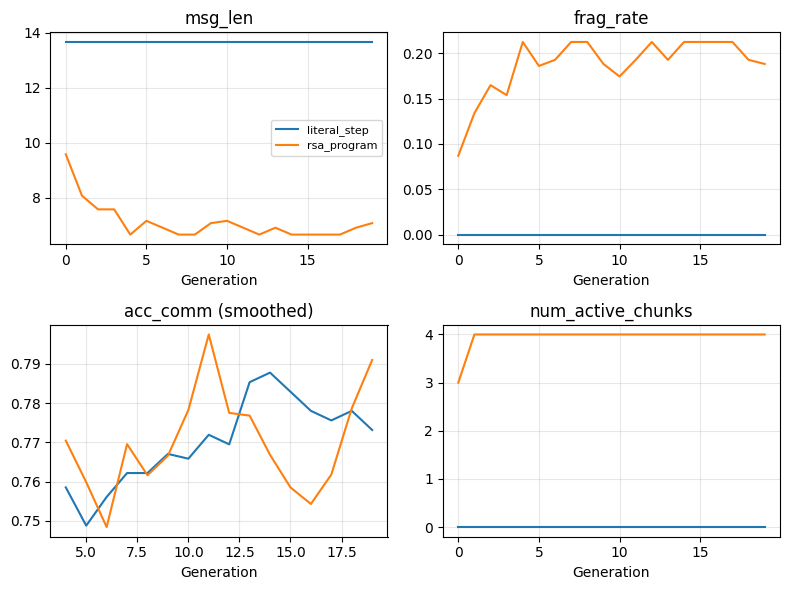

In [44]:
if SHOW_PLOTS:
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    for model_label, sub_df in [("literal_step", literal_df), ("rsa_program", rsa_df)]:
        axes[0, 0].plot(sub_df["generation"], sub_df["msg_len"], label=model_label)
        axes[0, 1].plot(sub_df["generation"], sub_df["frag_rate"], label=model_label)
        axes[1, 0].plot(sub_df["generation"], pd.Series(list(sub_df["acc_comm"])).rolling(window=5).mean(), label=model_label)
        axes[1, 1].plot(sub_df["generation"], sub_df["num_active_chunks"], label=model_label)
    axes[0, 0].set_title("msg_len")
    axes[0, 1].set_title("frag_rate")
    axes[1, 0].set_title("acc_comm (smoothed)")
    axes[1, 1].set_title("num_active_chunks")
    for ax in axes.flat:
        ax.set_xlabel("Generation")
        ax.grid(alpha=0.3)
    axes[0, 0].legend(fontsize=8)
    plt.tight_layout()
    plt.show()



`program_level`

For each trial there are multiple equivalent program representations with lengths $L$. If the speaker chooses a representation of length $L_{\text{chosen}}$, $\text{program\_level}=\frac{L_{\max}-L_{\text{chosen}}}{\max(1,\;L_{\max}-L_{\min})}.$

So $0$ means the speaker used the most expanded/primitive form, and $1$ means the most compressed/chunked form available for that trial.

`program_choice_entropy`

When the speaker forms a softmax over candidate programs $p \in \mathcal{P}$: $P(p)=\mathrm{softmax}(\alpha_{\text{prog}}\,U(p)).$

Measure of confidence entropy $H=-\sum_{p\in\mathcal{P}} P(p)\log P(p).$

`lexeme_mapping_entropy`

Just as above, $H=-\sum_a P(a\mid u)\log P(a\mid u),$
and average over utterances (and across speaker/listener posteriors). Lower means more confident, sharper conventions.

`reuse_chunk_rate`

Within a generation, let $C_{\text{used}}$ be the set of chunk actually used in produced programs, and $C_{\text{seen}}$ used in any previous generation. Then $
\text{reuse\_chunk\_rate}=\frac{|C_{\text{used}}\cap C_{\text{seen}}|}{\max(1,\;|C_{\text{used}}|)}.$



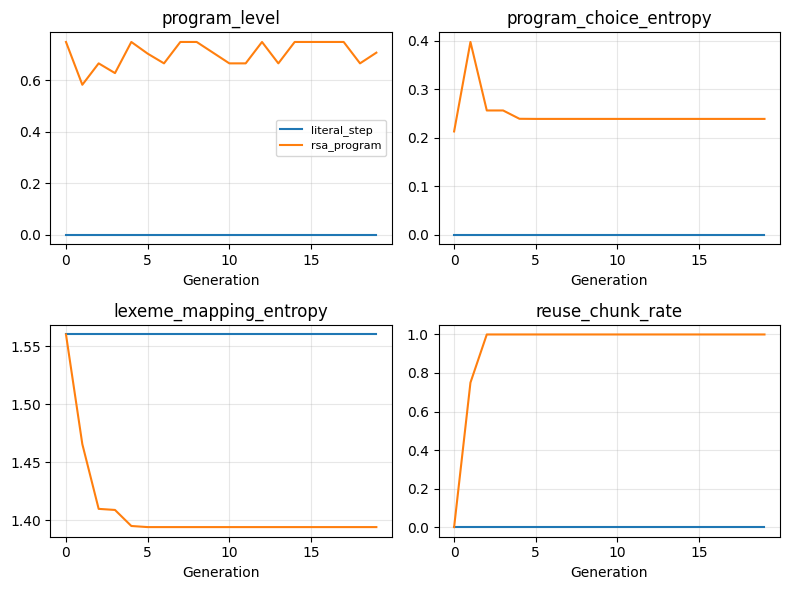

In [45]:
if SHOW_PLOTS:
    fig, axes = plt.subplots(2, 2, figsize=(8, 6))
    for model_label, sub_df in [("literal_step", literal_df), ("rsa_program", rsa_df)]:
        axes[0, 0].plot(sub_df["generation"], sub_df["program_level"], label=model_label)
        axes[0, 1].plot(sub_df["generation"], sub_df["program_choice_entropy"], label=model_label)
        axes[1, 0].plot(sub_df["generation"], pd.Series(list(sub_df["lexeme_mapping_entropy"])), label=model_label)
        axes[1, 1].plot(sub_df["generation"], sub_df["reuse_chunk_rate"], label=model_label)
    
    axes[0, 0].set_title("program_level")
    axes[0, 1].set_title("program_choice_entropy")
    axes[1, 0].set_title("lexeme_mapping_entropy")
    axes[1, 1].set_title("reuse_chunk_rate")

    for ax in axes.flat:
        ax.set_xlabel("Generation")
        ax.grid(alpha=0.3)
    axes[0, 0].legend(fontsize=8)
    plt.tight_layout()
    plt.show()



In [57]:
def eval_on_test(label, ppt_id, seed, arch_prior, build_prior, active_chunks):
    speaker_mode = str(label).split("_gen", 1)[0]
    df = run_comm_chain_bayes_rsa(
        ppt_id=int(ppt_id),
        data_model_dir=os.path.join(ROOT_DIR, "data", "model"),
        num_generations=1,
        lexemes=LEXEMES,
        speaker_mode=str(speaker_mode),
        min_attempts=0,
        min_success_rate=0.0,
        p_innovate=0.0,
        pre_promote_chunk_correct=1.0,
        max_promote_per_gen=0,
        speaker_alpha_prog=SPEAKER_ALPHA_PROG,
        speaker_alpha_utt=SPEAKER_ALPHA_UTT,
        speaker_beta_cost=SPEAKER_BETA_COST,
        epsilon=EPSILON,
        random_seed=int(seed),
        source_subdir=SOURCE_SUBDIR,
        init_arch_prior=arch_prior,
        init_build_prior=build_prior,
        init_active_chunks=active_chunks,
        freeze_updates=True,
    )
    return {
        "label": label,
        "speaker_mode": str(speaker_mode),
        "ppt_id": int(ppt_id),
        "seed": int(seed),
        "acc_comm": float(df["acc_comm"].iloc[0]),
        "msg_len": float(df["msg_len"].iloc[0]),
        "frag_rate": float(df["frag_rate"].iloc[0]),
        "program_choice_entropy": float(df["program_choice_entropy"].iloc[0]),
        "lexeme_mapping_entropy": float(df["lexeme_mapping_entropy"].iloc[0]),
    }

In [58]:
jobs = []
for ppt_id in TEST_PPT_IDS:
    for rep in range(int(TEST_NUM_REPEATS)):
        seed = int(SEED + 1000 + 17 * int(ppt_id) + rep)
        jobs.append(("literal_step_gen0", ppt_id, seed, None, None, None))
        jobs.append(("literal_step_gen20", ppt_id, seed, literal_state["arch_prior"], literal_state["build_prior"], literal_state["active_chunks"]))
        jobs.append(("rsa_program_gen20", ppt_id, seed, rsa_state["arch_prior"], rsa_state["build_prior"], rsa_state["active_chunks"]))

if TEST_MAX_WORKERS <= 1:
    results = [eval_on_test(*j) for j in jobs]
else:
    with ThreadPoolExecutor(max_workers=int(TEST_MAX_WORKERS)) as pool:
        results = list(pool.map(lambda j: eval_on_test(*j), jobs))

In [59]:
gen_runs = pd.DataFrame(results)

In [63]:
summary_cols = ["acc_comm", "msg_len", "frag_rate", "program_choice_entropy", "lexeme_mapping_entropy"]
gen_summary = (
    gen_runs.groupby("label")[summary_cols]
    .agg(["mean", "std"])
    .reset_index()
)
gen_summary

label  acc_comm              msg_len           frag_rate  \
                           mean       std       mean       std      mean   
0   literal_step_gen0  0.781250  0.029398  13.666667  0.000000  0.000000   
1  literal_step_gen20  0.781250  0.029398  13.666667  0.000000  0.000000   
2   rsa_program_gen20  0.780718  0.025983   7.131944  0.377441  0.184089   

            program_choice_entropy           lexeme_mapping_entropy       
        std                   mean       std                   mean  std  
0  0.000000               0.000000  0.000000               1.560338  0.0  
1  0.000000               0.000000  0.000000               1.560338  0.0  
2  0.020483               0.230317  0.023392               1.394037  0.0

In [61]:
def print_trace(trace_df, max_trials=2, max_steps=30):
    if trace_df is None or len(trace_df) == 0:
        print("  (no trace data)")
        return
    trials = sorted(list(set(int(x) for x in trace_df["trial"].tolist())))
    for t in trials[:max_trials]:
        sub = trace_df[trace_df["trial"] == t].copy()
        if len(sub) == 0:
            continue
        prog = str(list(sub["target_program"])[0])
        print(f"  trial={t} target_program={prog}")
        for i, (_, r) in enumerate(sub.iterrows()):
            if i >= max_steps:
                print("    ... truncated ...")
                break
            intent = str(r["intention"])
            utt = str(r["utterance"])
            resp = str(r["response"])
            mark = "*" if intent == resp else " "
            print(f"    {mark} {intent} | utt={utt} | resp={resp}")

In [62]:

for g in TRACE_GENS:
    print(f"Generation {g}:")
    if g in literal_traces:
        print("\n LITERAL_STEP TRACES ")
        print_trace(literal_traces[g])
    if g in rsa_traces:
        print("\n RSA_PROGRAM TRACES ")
        print_trace(rsa_traces[g])

Generation 0:

 LITERAL_STEP TRACES 
  trial=1 target_program=h l_4 h l_1 v v r_9 v r_6 v l_5 h r_4 h
    * h | utt=place a horizontal block. | resp=h
    * l_4 | utt=move to the left by 4 | resp=l_4
      h | utt=place a horizontal block. | resp=l_8
    * l_1 | utt=move to the left by 1 | resp=l_1
    * v | utt=place a vertical block. | resp=v
      v | utt=place a vertical block. | resp=r_9
    * r_9 | utt=move to the right by 9 | resp=r_9
    * v | utt=place a vertical block. | resp=v
      r_6 | utt=move to the right by 6 | resp=r_1
    * v | utt=place a vertical block. | resp=v
    * l_5 | utt=move to the left by 5 | resp=l_5
      h | utt=place a horizontal block. | resp=r_3
    * r_4 | utt=move to the right by 4 | resp=r_4
      h | utt=place a horizontal block. | resp=l_3
  trial=2 target_program=h l_4 h l_1 v v r_12 h l_1 v v r_1 h
    * h | utt=place a horizontal block. | resp=h
    * l_4 | utt=move to the left by 4 | resp=l_4
    * h | utt=place a horizontal block. | resp=h
